# Progetto avanzato

# Indice

- [Inizializzazione del Notebook](#inizial)
  - [Installazioni](#install)
  - [Import](#import)
  - [Utils](#utils)
- [Importazione ed elaborazione dei dati](#dati)
  - [Lettura dati](#lett_dati)
  - [Conversione da rating a classe](#rating_class)
  - [Distribuzione delle classi](#distr_classi)
- [Sentiment Analysis](#sent_analysis)
  - [Embedding con BOW - lemmatizing](#bow_lemm)
  - [Embedding con BOW - stemming](#bow_stem)
  - [Embedding con TFIDF - lemmatizing](#tfidf_lemm)
  - [Embedding con TFIDF - stemming](#tfidf_stem)
  - [Trasformers](#transfomers)


# Inizializzazione del Notebook <a class="anchor"  id="inizial"></a>

## Installazioni <a class="anchor"  id="install"></a>

In [1]:
!pip install datasets

In [2]:
!pip install nltk
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')

!pip install sentence-transformers

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 7.0 MB/s eta 0:00:00


In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

## Import <a class="anchor"  id="import"></a>

In [4]:
from datasets import load_dataset

from surprise.model_selection import train_test_split

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, show
output_notebook()

import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer

Loading BokehJS ...

2024-06-12 12:44:40.193239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 12:44:40.193374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 12:44:40.347376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [6]:
stop_words.update([',','.','!','?',';','-','...','[',']','{','}','(',')','&',':', '--','<','>','^','#','\\','/','\'','\"','br', '<br />', '\'s', '&#34', '34', 'n\'t', '\`', "''", '``'])

## Utils <a class="anchor"  id="utils"></a>

In [7]:
def text_processing(sentences, method="lemmatize"):
    tokenized_sentences = []
    for i, text in enumerate(sentences) :
        word_token = word_tokenize(text)
        tokens = []
        for word in word_token:
            if word.casefold() not in stop_words:
                if method == "lemmatize":
                    tokens.append(lemmatizer.lemmatize(word))
                else:
                    tokens.append(stemmer.stem(word))
        tokenized_sentences.append(tokens)
    return tokenized_sentences

In [8]:
def cut_dataset(reviews, min_n_reviews_user, min_n_reviews_item):
    user_review_count = reviews.groupby("user_id").count()[["parent_asin"]].reset_index()
    print("numero di utenti: ", len(user_review_count[user_review_count["parent_asin"] > 0]))
    print("numero di utenti con un numero di recensioni > ", min_n_reviews_user, " : ", len(user_review_count[user_review_count["parent_asin"] > min_n_reviews_user]))
    users_id = user_review_count[user_review_count["parent_asin"] > min_n_reviews_user]["user_id"].unique().tolist()

    item_review_count = reviews.groupby("parent_asin").count()[["user_id"]].reset_index()
    print("numero di item: ", len(item_review_count[item_review_count["user_id"] > 0]))
    print("numero di item con un numero di recensioni > ", min_n_reviews_item, " : ", len(item_review_count[item_review_count["user_id"] > min_n_reviews_item]))
    items_id = item_review_count[item_review_count["user_id"] > min_n_reviews_item]["parent_asin"].tolist()

    reviews = reviews[(reviews["rating"] == 5) & (reviews["timestamp"] >= 1574259418783) | (reviews["rating"] <= 4)]
    
    reviews = reviews[reviews["user_id"].isin(users_id)].reset_index(drop=True)
    reviews = reviews[reviews["parent_asin"].isin(items_id)].reset_index(drop=True)

    # users_id e items_id vengono "risettati" in quanto può essere che un utente abbia dato due recensioni (e quindi venga incluso nella prima lista)
    # ma che le due recensioni appartengano a prodotti che hanno solo una recensione e quindi vengono eliminate le reviews -> quindi gli utenti (o gli item)
    # in questione non hanno più reviews (e il numero diminuisce)

    return reviews, reviews["user_id"].unique(), reviews["parent_asin"].unique()

In [9]:
def add_title(df):
    df["text"] = df["title"]+ " " +df["text"]
    return df

In [10]:
def create_bag_of_words(tokenized_sentences):# create the vocabulary
    vocab = set()

    # create the bag-of-words model
    bow_model = []

    for tokens in tokenized_sentences:
        # create a dictionary to store the word counts
        word_counts = {}

        # update the vocabulary
        vocab.update(tokens)

        # count the occurrences of each word
        for word in tokens:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

        # add the word counts to the bag-of-words model
        bow_model.append(word_counts)
    return bow_model, vocab

In [11]:
def identity_tokenizer(text):
    return text

In [12]:
def create_TFIDF(tokenized_sentences):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase = False)
    tfidf_model = vectorizer.fit_transform(tokenized_sentences)
    return tfidf_model.toarray(), vectorizer.get_feature_names_out()

In [13]:
def create_bow_data(vocab, reviews_data):
    data = pd.DataFrame(0, index=range(len(reviews_data)), columns=list(vocab))
    for i in range(len(reviews_data)):
        if i % 1000 == 0: 
            print(i)
        data.loc[i, reviews_data[i].keys()] = reviews_data[i].values()
    return data

In [14]:
def create_tfidf_data(vocab, tfidf_reviews):
    data = pd.DataFrame(0.0, index=range(len(tfidf_reviews)), columns=list(vocab))
    for i in range(len(tfidf_reviews)):
        if i % 1000 == 0: 
            print(i)
        data.loc[i, vocab] = tfidf_reviews[i]
    return data

In [15]:
def sentiment_analysis(data, test_size = 0.20, n_neighbors = 20):
    # Split the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["parent_asin", "classe"]), 
                                                    pd.Series(data['classe']),
                                                    test_size=test_size,
                                                    train_size=1 - test_size)
    
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(X_train, y_train)
    
    y_pred = neigh.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels = ["negativo", "neutro", "positivo"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["negativo", "neutro", "positivo"])
    disp.plot()

# Importazione ed elaborazione dei dati <a class="anchor"  id="dati"></a>

## Lettura dati <a class="anchor"  id="lett_dati"></a>

In [16]:
reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Software", trust_remote_code=True)
reviews = reviews["full"].to_pandas()

Generating full split: 0 examples [00:00, ? examples/s]

In [17]:
items_info = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Software", split="full", trust_remote_code=True)

Generating full split: 0 examples [00:00, ? examples/s]

In [18]:
reviews, users_id, items_id = cut_dataset(reviews, 50, 180) 

numero di utenti:  2589466
numero di utenti con un numero di recensioni >  50  :  796
numero di item:  89246
numero di item con un numero di recensioni >  180  :  3069


In [19]:
items_info = items_info.filter(lambda row: row["parent_asin"] in items_id)

Filter:   0%|          | 0/89251 [00:00<?, ? examples/s]

## Conversione da rating a classe <a class="anchor"  id="rating_class"></a>

In [20]:
def add_class(df):
    
    df["classe"] =  "neutro" if df["rating"] == 3 else "positivo" if df["rating"] == 4 or df["rating"] == 5 else "negativo" 
    return df

In [21]:
reviews = reviews.apply(add_class, axis=1)
reviews["classe"].unique()

array(['positivo', 'negativo', 'neutro'], dtype=object)

In [22]:
reviews.apply(add_title, axis = 1)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,classe
0,4.0,Movies,Movies Good apps. But have code for digital an...,[],B075VFR5DB,B075VFR5DB,AHFZUNQFXSVVT6Z6BYKE5CLBX3KQ,1655652246638,4,True,positivo
1,5.0,Love it,Love it Great video,[],B0117U0G3M,B0117U0G3M,AHFZUNQFXSVVT6Z6BYKE5CLBX3KQ,1655651148217,19,True,positivo
2,1.0,Game,Game Ok,[],B01CBV2K8U,B01CBV2K8U,AHFZUNQFXSVVT6Z6BYKE5CLBX3KQ,1630176137276,8,True,negativo
3,1.0,Game,Game Ok,[],B017BLMEJK,B017BLMEJK,AHFZUNQFXSVVT6Z6BYKE5CLBX3KQ,1630176005094,1,True,negativo
4,2.0,Game,Game Ok,[],B01HBJ4MPQ,B01HBJ4MPQ,AHFZUNQFXSVVT6Z6BYKE5CLBX3KQ,1630175859628,5,True,negativo
...,...,...,...,...,...,...,...,...,...,...,...
20209,1.0,free? obstacles...,free? obstacles... I think this game is ok and...,[],B00LDNE3FG,B00LDNE3FG,AGB66SMO6GGQTQWYR5R2VJWEACXQ,1405634089000,5,True,negativo
20210,1.0,One Star,One Star I don't like it.. too hard,[],B00PB5AO4G,B00PB5AO4G,AGB66SMO6GGQTQWYR5R2VJWEACXQ,1494568007000,0,True,negativo
20211,1.0,not so great,"not so great This is boring, interesting but b...",[],B00OPYZORG,B00OPYZORG,AGB66SMO6GGQTQWYR5R2VJWEACXQ,1426419973000,1,True,negativo
20212,2.0,can't sign in,"can't sign in Hello, I can't register or sign ...",[],B00N9L9QKM,B00N9L9QKM,AGB66SMO6GGQTQWYR5R2VJWEACXQ,1411534845000,4,True,negativo


## Distribuzione delle classi <a class="anchor"  id="distr_classi"></a>


In [23]:
ratings = ["Negativo","Neutro","Positivo"]
counts = reviews.groupby("rating").count()[["parent_asin"]].values[:,0]
print(counts)
counts_classi = np.zeros((3))
counts_classi[0] = counts[0] + counts[1]
counts_classi[1] = counts[2]
counts_classi[2] = counts[3] + counts[4]
print(counts_classi)
p = figure(x_range=ratings, height=350, title="Class Counts")

p.vbar(x=ratings, top=counts_classi, width=0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p, notebook_handle=True) #plot della distribuzione dei ratings

[3955 2248 5208 5537 3266]
[6203. 5208. 8803.]


# Sentiment Analysis <a class="anchor"  id="sent_analysis"></a>

## Embedding con BOW - lemmatizing <a class="anchor"  id="bow_lemm"></a>

In [24]:
user_reviews_tokens = text_processing(reviews["text"], "lemmatize")

In [25]:
bow_lemmatized_user_reviews, bow_vocab_lemmatized = create_bag_of_words(user_reviews_tokens)

In [26]:
bow_lemmatized_data = create_bow_data(bow_vocab_lemmatized, bow_lemmatized_user_reviews)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [27]:
bow_lemmatized_data["parent_asin"] = reviews["parent_asin"]
bow_lemmatized_data["classe"] = reviews["classe"]

              precision    recall  f1-score   support

    negativo       0.50      0.74      0.59      1233
      neutro       0.59      0.33      0.43      1037
    positivo       0.70      0.64      0.66      1773

    accuracy                           0.59      4043
   macro avg       0.59      0.57      0.56      4043
weighted avg       0.61      0.59      0.58      4043



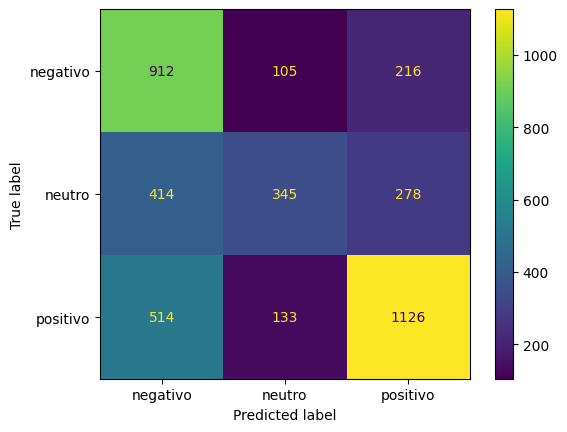

In [28]:
sentiment_analysis(bow_lemmatized_data)

## Embedding con BOW - stemming <a class="anchor"  id="bow_stem"></a>

In [29]:
user_reviews_tokens = text_processing(reviews["text"], "stem")

In [30]:
bow_stemmed_user_reviews, bow_vocab_stemmed = create_bag_of_words(user_reviews_tokens)

In [31]:
bow_stemmed_data = create_bow_data(bow_vocab_stemmed, bow_stemmed_user_reviews)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [32]:
bow_stemmed_data["parent_asin"] = reviews["parent_asin"]
bow_stemmed_data["classe"] = reviews["classe"]

              precision    recall  f1-score   support

    negativo       0.56      0.68      0.61      1263
      neutro       0.56      0.38      0.45      1011
    positivo       0.69      0.71      0.70      1769

    accuracy                           0.62      4043
   macro avg       0.60      0.59      0.59      4043
weighted avg       0.62      0.62      0.61      4043



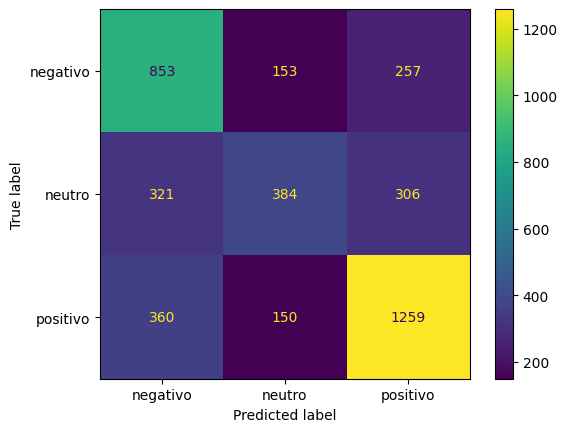

In [33]:
sentiment_analysis(bow_stemmed_data)

## Embedding con TFIDF - lemmatizing <a class="anchor"  id="tfidf_lemm"></a>

In [34]:
user_reviews_tokens = text_processing(reviews["text"], "lemmatize")

In [35]:
tfidf_lemmatized_user_reviews, tfidf_vocab_lemmatized = create_TFIDF(user_reviews_tokens)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [36]:
tfidf_lemmatized_data = create_tfidf_data(tfidf_vocab_lemmatized, tfidf_lemmatized_user_reviews)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [37]:
tfidf_lemmatized_data["parent_asin"] = reviews["parent_asin"]
tfidf_lemmatized_data["classe"] = reviews["classe"]

              precision    recall  f1-score   support

    negativo       0.39      0.89      0.54      1232
      neutro       0.63      0.24      0.35      1037
    positivo       0.76      0.36      0.49      1774

    accuracy                           0.49      4043
   macro avg       0.59      0.50      0.46      4043
weighted avg       0.61      0.49      0.47      4043



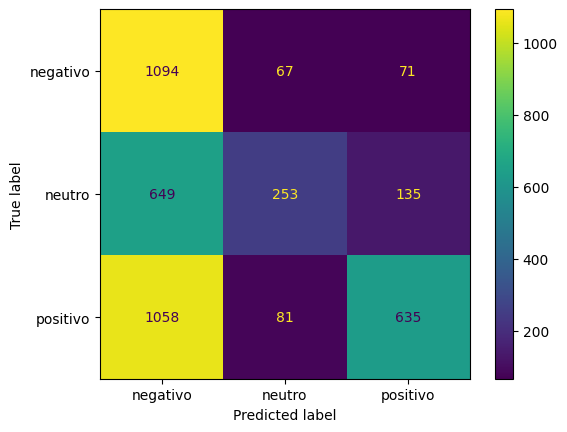

In [38]:
sentiment_analysis(tfidf_lemmatized_data)

## Embedding con TFIDF - stemming <a class="anchor"  id="tfidf_stem"></a>

In [39]:
user_reviews_tokens = text_processing(reviews["text"], "stem")

In [40]:
tfidf_stemmed_user_reviews, tfidf_vocab_stemmed = create_TFIDF(user_reviews_tokens)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [41]:
tfidf_stemmed_data = create_tfidf_data(tfidf_vocab_stemmed, tfidf_stemmed_user_reviews)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [42]:
tfidf_stemmed_data["parent_asin"] = reviews["parent_asin"]
tfidf_stemmed_data["classe"] = reviews["classe"]

              precision    recall  f1-score   support

    negativo       0.40      0.83      0.54      1218
      neutro       0.52      0.35      0.42      1034
    positivo       0.77      0.34      0.47      1791

    accuracy                           0.49      4043
   macro avg       0.56      0.51      0.48      4043
weighted avg       0.59      0.49      0.48      4043



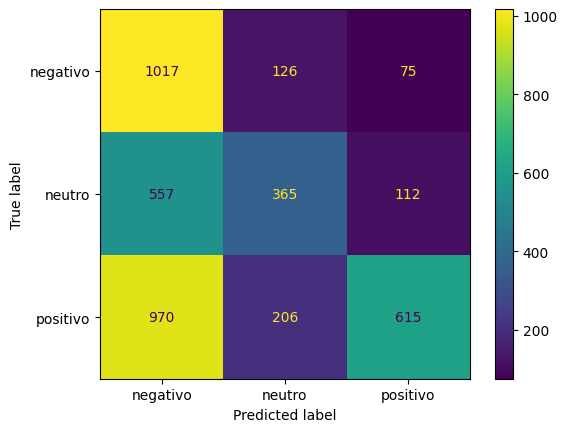

In [43]:
sentiment_analysis(tfidf_stemmed_data)

## Trasformers <a class="anchor"  id="transfomers"></a>

In [44]:
model = SentenceTransformer('ashok2216/gpt2-amazon-sentiment-classifier-V1.0') 

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [45]:
reviews_embeddings = model.encode(reviews["text"]) 

Batches:   0%|          | 0/632 [00:00<?, ?it/s]

In [46]:
transformer_data = pd.DataFrame(reviews_embeddings)
transformer_data["parent_asin"] = reviews["parent_asin"]
transformer_data["classe"] = reviews["classe"]
transformer_data

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,parent_asin,classe
0,-0.081129,0.579583,0.218575,0.487491,0.446774,-0.369639,-0.175027,0.485522,0.406017,-0.009423,...,-0.730864,-0.789226,-0.285089,0.412433,0.228430,-0.185634,0.233694,0.063538,B075VFR5DB,positivo
1,0.423309,-0.207436,0.497754,-0.063343,0.015234,-0.669555,0.485529,0.465210,-0.221560,-0.250432,...,0.153301,-0.817118,-0.157290,-0.050069,0.120364,-0.514231,-0.398578,-0.163454,B0117U0G3M,positivo
2,0.080873,0.226063,0.027430,-0.042584,-0.029120,-0.386485,0.662500,0.102175,0.050597,-0.208517,...,-0.084305,-0.646681,-0.064515,-0.413461,0.075553,-0.109730,-0.029370,0.339761,B01CBV2K8U,negativo
3,0.080873,0.226063,0.027430,-0.042584,-0.029120,-0.386485,0.662501,0.102175,0.050597,-0.208518,...,-0.084305,-0.646681,-0.064515,-0.413461,0.075554,-0.109730,-0.029370,0.339761,B017BLMEJK,negativo
4,0.080873,0.226063,0.027430,-0.042584,-0.029120,-0.386485,0.662500,0.102175,0.050597,-0.208517,...,-0.084305,-0.646681,-0.064515,-0.413461,0.075553,-0.109730,-0.029370,0.339761,B01HBJ4MPQ,negativo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20209,-0.129631,0.318053,0.034232,0.238127,0.293715,-0.197319,0.006660,0.508412,0.132609,0.021463,...,-0.636915,-0.862885,-0.206385,0.178580,0.118759,0.329084,-0.059059,0.234711,B00LDNE3FG,negativo
20210,0.099365,0.100456,0.446986,-0.100244,-0.079001,-0.058514,0.164455,0.725800,0.245178,-0.322063,...,-0.667276,-1.098780,-0.498979,-0.372267,-0.368275,0.096581,0.008023,-0.036720,B00PB5AO4G,negativo
20211,0.506429,1.190441,0.381575,0.355200,0.216610,-0.728499,0.184254,0.928982,0.190360,0.074437,...,-0.952294,-0.932410,0.150706,0.053830,-0.027081,-0.321760,0.333743,0.501499,B00OPYZORG,negativo
20212,0.014568,0.432983,0.160543,0.260854,0.434980,-0.385227,0.300012,0.626267,0.094645,0.181603,...,-0.436055,-0.905765,-0.479881,0.547321,-0.004190,0.101708,-0.082592,0.319840,B00N9L9QKM,negativo


              precision    recall  f1-score   support

    negativo       0.70      0.77      0.73      1210
      neutro       0.54      0.42      0.47      1047
    positivo       0.75      0.80      0.78      1786

    accuracy                           0.69      4043
   macro avg       0.66      0.66      0.66      4043
weighted avg       0.68      0.69      0.68      4043



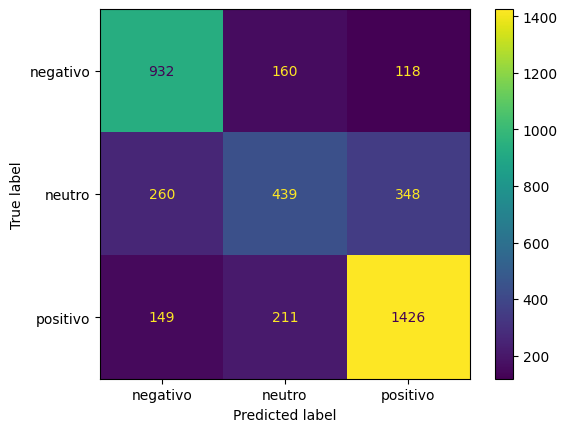

In [47]:
sentiment_analysis(transformer_data)